In [2]:
pip install imutils

Note: you may need to restart the kernel to use updated packages.


In [3]:
import cv2 as cv
import os
from imutils import paths
from keras.preprocessing.image import img_to_array
print("[INFO] Loading Images...")
imagePaths = list(paths.list_images('../input/smiledetection/Smile_Detection-master/dataset/SMILEsmileD/SMILEs'))
data = []
labels = []
for (i,imagePath) in enumerate(imagePaths):
  image = cv.imread(imagePath,0)
  image = cv.resize(image,(32,32))
  image = img_to_array(image)
  label = imagePath.split(os.path.sep)[-3]
  data.append(image)
  labels.append(label)
  if i>0 and (i+1)%2000==0:
    print("[INFO] processed {}/{}".format(i+1,len(imagePaths)))
print("[INFO] Finished Loading Images...")

Using TensorFlow backend.


[INFO] Loading Images...
[INFO] processed 2000/13165
[INFO] processed 4000/13165
[INFO] processed 6000/13165
[INFO] processed 8000/13165
[INFO] processed 10000/13165
[INFO] processed 12000/13165
[INFO] Finished Loading Images...


In [4]:
import numpy as np
#for handling over sampled negatives.
unique, counts = np.unique(labels, return_counts=True)

print(dict(zip(unique, counts)))
class_weight = {0: 1., 1: (9475/3690)}
print(class_weight)    

{'negatives': 9475, 'positives': 3690}
{0: 1.0, 1: 2.567750677506775}


In [5]:
from sklearn.preprocessing import LabelEncoder
from keras.utils import np_utils
le = LabelEncoder().fit(labels)
labels = np_utils.to_categorical(le.transform(labels), 2)

In [6]:
import numpy as np
data = np.array(data,dtype='float')/255.0
labels = np.array(labels)

In [7]:
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(data, labels, test_size=0.25, random_state=42)

In [8]:
from keras.models import Sequential
from keras.layers import Conv2D,MaxPool2D,Activation,Flatten,Dense

def leNet_model(width, height, channels,classes):
  model = Sequential()
  
  model.add(Conv2D(20,(5,5),input_shape=(height,width,channels)))
  model.add(Activation('relu'))
  model.add(MaxPool2D(2,2))

  model.add(Conv2D(50,(5,5)))
  model.add(Activation('relu'))
  model.add(MaxPool2D(2,2))
  model.add(Flatten())

  model.add(Dense(500))
  model.add(Activation('relu'))

  model.add(Dense(classes))
  model.add(Activation('softmax'))

  return model

In [9]:
print(x_train.shape,x_test.shape,y_train.shape,y_test.shape)

(9873, 32, 32, 1) (3292, 32, 32, 1) (9873, 2) (3292, 2)


In [10]:
y_test

array([[1., 0.],
       [1., 0.],
       [1., 0.],
       ...,
       [0., 1.],
       [1., 0.],
       [1., 0.]], dtype=float32)

In [11]:
model = leNet_model(32,32,1,2)
from keras.optimizers import SGD
opt = SGD(learning_rate=0.01,momentum=0.9,nesterov=True)
model.compile(optimizer=opt, metrics=['accuracy'], loss="binary_crossentropy")

model.fit(x_train,y_train,batch_size=32,
          epochs=40,verbose=1,
          class_weight=class_weight,
          validation_data=(x_test,y_test))

Train on 9873 samples, validate on 3292 samples
Epoch 1/40
9873/9873 [==============================] - 3s 329us/step - loss: 0.7213 - accuracy: 0.7418 - val_loss: 0.3459 - val_accuracy: 0.8584
Epoch 2/40
9873/9873 [==============================] - 1s 136us/step - loss: 0.5009 - accuracy: 0.8522 - val_loss: 0.3258 - val_accuracy: 0.8651
Epoch 3/40
9873/9873 [==============================] - 1s 135us/step - loss: 0.4635 - accuracy: 0.8646 - val_loss: 0.2690 - val_accuracy: 0.8955
Epoch 4/40
9873/9873 [==============================] - 1s 137us/step - loss: 0.4402 - accuracy: 0.8740 - val_loss: 0.4344 - val_accuracy: 0.8071
Epoch 5/40
9873/9873 [==============================] - 1s 136us/step - loss: 0.4028 - accuracy: 0.8867 - val_loss: 0.2681 - val_accuracy: 0.8973
Epoch 6/40
9873/9873 [==============================] - 1s 136us/step - loss: 0.3851 - accuracy: 0.8941 - val_loss: 0.2501 - val_accuracy: 0.9031
Epoch 7/40
9873/9873 [==============================] - 1s 138us/step - loss

In [83]:
import cv2 as cv
from keras.preprocessing.image import img_to_array
import numpy as np
face_cascade = cv.CascadeClassifier('../input/frontalface-xml/front_face.xml')

def detect_face(img):
    faces = face_cascade.detectMultiScale(img.astype('uint8'),1.3,5)
    roi = None
    if faces is not None:
      for (x,y,w,h) in faces:
          img = cv.rectangle(img,(x,y),(x+w,y+h),(255,0,0),2)
          roi = img[y:y+h, x:x+w]
          roi = cv.resize(roi,(32,32))
          roi = roi/255.0
          roi = img_to_array(roi)
          roi = np.expand_dims(roi,axis=0)
    return roi

img1 = cv.imread("../input/therock/images.jfif",0)
img2 = cv.imread("../input/notsmiling/notsmiling.jfif",0)

roi1 = detect_face(img1)
roi2 = detect_face(img2)

In [96]:
def get_Output(predict,img):
    if predict[0][0]>predict[0][1] :
      img = cv.putText(img,"NotSmiling",(img.shape[1]-200,img.shape[0]-10),cv.FONT_HERSHEY_COMPLEX,1,(0,255,0),1)
    else:
      img = cv.putText(img,"Smiling",(faces[0][2],faces[0][3]+50),cv.FONT_HERSHEY_COMPLEX,1,(0,255,0),1)
    return img

predict1 = model.predict(roi1)
predict2 = model.predict(roi2)

print(img2.shape)

img1 = get_Output(predict1,img1)
img2 = get_Output(predict2,img2)

(207, 243)


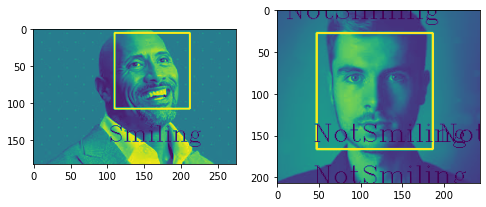

In [97]:
w=10
h=10
fig=plt.figure(figsize=(8, 8))
columns = 2
rows = 1
for i in range(1, columns*rows +1):
    fig.add_subplot(rows, columns, i)
    plt.imshow(eval("img"+str(i)))
plt.show()